## Exercise 1.4 Hotdog -- no hotdog
This is the first poster hand-in exercise for the course. Please see the associated PDF for instructions.

In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [3]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='../hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [4]:
size = 128
rotation_range = 20

# train_transform = transforms.Compose([transforms.Resize((size, size)), 
#                                     transforms.ToTensor(),
#                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
#                                     transforms.RandomRotation(rotation_range),

#                                     ])
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor(),
                                    ])

train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((size, size)),
    transforms.ToTensor()
])

batch_size = 16
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)


Let's look at some images from our data 

In [5]:
# images, labels = next(iter(train_loader))
# plt.figure(figsize=(20,10))

# for i in range(21):
#     plt.subplot(5,7,i+1)
#     plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
#     plt.title(['hotdog', 'not hotdog'][labels[i].item()])
#     plt.axis('off')


Now create a model and train it!


In [6]:

init_type = init=nn.init.xavier_uniform_

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.convolutional1 = nn.Sequential(
                nn.Conv2d(3, 128, kernel_size=7, padding=3),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2),
        )

        self.convolutional2 = nn.Sequential(
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.BatchNorm2d(256,eps=1e-04),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2),
        )
        
        self.convolutional3 = nn.Sequential(
                nn.Conv2d(256, 128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128,eps=1e-04),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2),
        )
        self.convolutional4 = nn.Sequential(
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128,eps=1e-04),
                nn.ReLU(inplace=True),
        )
        

        self.fully_connected = nn.Sequential(
                nn.Linear(16*16*128, 1024),
                nn.ReLU(),
                nn.Dropout(0.40),
                nn.Linear(1024, 512),
                nn.ReLU(),
                nn.Dropout(0.40),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, 64),
                nn.ReLU(),
                nn.Linear(64, 2),
                # nn.Softmax(dim=1)
                )
        
    def forward(self, x):
        x = self.convolutional1(x)
        x = self.convolutional2(x)
        x = self.convolutional3(x)
        x = self.convolutional4(x)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        
        return x
    
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

In [7]:
model = Network()
model.apply(init_weights)
model.to(device)
#Initialize the optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00004, weight_decay=0.1)

In [8]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    def loss_fun(output, target):
        return F.cross_entropy(output, target)
    out_dict = {
              'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict



In [9]:
out_dict = train(model, optimizer, num_epochs=25)

  0%|          | 0/25 [00:00<?, ?epoch/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.807	 test: 0.661	 Accuracy train: 57.7%	 test: 65.4%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.675	 test: 0.565	 Accuracy train: 65.4%	 test: 71.6%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.640	 test: 0.647	 Accuracy train: 68.0%	 test: 66.5%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.602	 test: 0.562	 Accuracy train: 69.8%	 test: 72.2%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.553	 test: 0.518	 Accuracy train: 73.1%	 test: 74.7%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.517	 test: 0.523	 Accuracy train: 75.2%	 test: 75.0%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.517	 test: 0.579	 Accuracy train: 74.5%	 test: 71.9%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.501	 test: 0.527	 Accuracy train: 76.9%	 test: 73.2%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.490	 test: 0.500	 Accuracy train: 76.9%	 test: 76.6%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.485	 test: 0.477	 Accuracy train: 77.7%	 test: 78.8%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.464	 test: 0.662	 Accuracy train: 78.5%	 test: 67.4%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.481	 test: 0.477	 Accuracy train: 78.3%	 test: 78.4%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.469	 test: 0.504	 Accuracy train: 79.0%	 test: 75.1%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.456	 test: 0.517	 Accuracy train: 78.8%	 test: 75.7%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.456	 test: 0.500	 Accuracy train: 79.1%	 test: 77.2%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.457	 test: 0.470	 Accuracy train: 79.6%	 test: 77.4%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.449	 test: 0.498	 Accuracy train: 81.1%	 test: 76.9%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.452	 test: 0.503	 Accuracy train: 79.6%	 test: 77.2%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.441	 test: 0.461	 Accuracy train: 80.0%	 test: 78.1%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.455	 test: 0.511	 Accuracy train: 79.4%	 test: 76.5%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.460	 test: 0.515	 Accuracy train: 78.8%	 test: 75.0%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.441	 test: 0.534	 Accuracy train: 80.0%	 test: 76.0%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.448	 test: 0.684	 Accuracy train: 79.7%	 test: 69.6%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.443	 test: 0.473	 Accuracy train: 80.9%	 test: 78.9%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.450	 test: 0.494	 Accuracy train: 79.2%	 test: 76.2%


Text(0, 0.5, 'Accuracy')

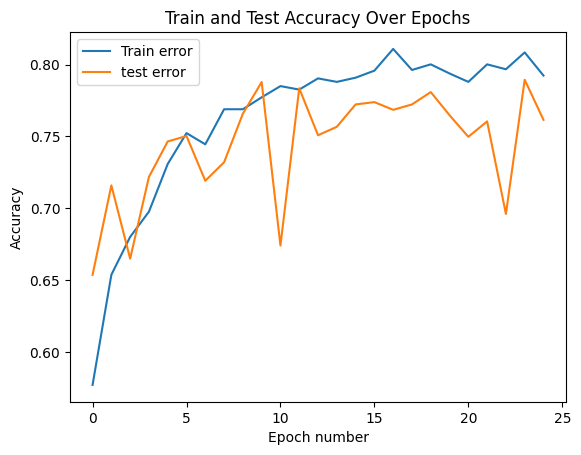

In [10]:
plt.plot(out_dict['train_acc'], label='Train Accuracy')
plt.plot(out_dict['test_acc'], label='Test Accuracy')
plt.title('Train and Test Accuracy Over Epochs')
plt.legend(('Train error','test error'))
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')

In [12]:
print("train accuracy: ")
print(out_dict['train_acc'])
print("test accuracy: " )
print(out_dict['test_acc'])

train accuracy: 
[0.5769418661455789, 0.6536394723986322, 0.680019540791402, 0.6976062530532486, 0.7308255984367367, 0.7523204689789936, 0.7445041524181729, 0.7689301416707377, 0.7689301416707377, 0.7772349780166097, 0.7850512945774304, 0.782608695652174, 0.7904250122129947, 0.7879824132877381, 0.7909135319980459, 0.7957987298485588, 0.810942843185149, 0.7962872496336102, 0.8001954079140206, 0.7938446507083536, 0.7879824132877381, 0.8001954079140206, 0.7967757694186615, 0.8085002442598925, 0.7923790913531998]
test accuracy: 
[0.6535982814178303, 0.7158968850698174, 0.664876476906552, 0.7218045112781954, 0.7465091299677766, 0.7502685284640171, 0.7191192266380236, 0.7320085929108485, 0.765843179377014, 0.7878625134264232, 0.6740064446831364, 0.7835660580021482, 0.7508055853920516, 0.7567132116004296, 0.7722878625134264, 0.7738990332975295, 0.7685284640171858, 0.7722878625134264, 0.7808807733619764, 0.7647690655209453, 0.7497314715359829, 0.7604726100966702, 0.6960257787325457, 0.78947368